In [1]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange
from skimage.filters import gaussian
from scipy.ndimage import uniform_filter1d
from numpy.polynomial import Polynomial

In [6]:
exp_sum = pd.read_excel('../Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
positions = pd.read_excel('../Positions.xlsx')
df = pd.read_excel('../data_processed.xlsx')

In [107]:
# Group by Date, Machine, Pad, and Dilution, and count the number of colonies in each group
colonies_per_pad_dilution = df.groupby(['Date', 'Machine', 'Pad', 'Dilution']).size().reset_index(name='colony_count')

# Compute the mean and standard deviation of the colony count per pad for each dilution
plot_data_colonies = colonies_per_pad_dilution.groupby('Dilution')['colony_count'].agg(['mean', 'std', 'sum']).reset_index()

# Compute the mean and standard deviation of the area per pad for each dilution
plot_data_area = mean_std_area_per_pad_dilution.reset_index()

# Merge the colony count data with the area data
plot_data = plot_data_area.merge(plot_data_colonies[['Dilution', 'sum']], on='Dilution')

In [108]:
plot_data_colonies

,Dilution,mean,std,sum
0,10^(-5),5.909091,3.803621,130
1,10^(-6),2.727273,4.125310,30


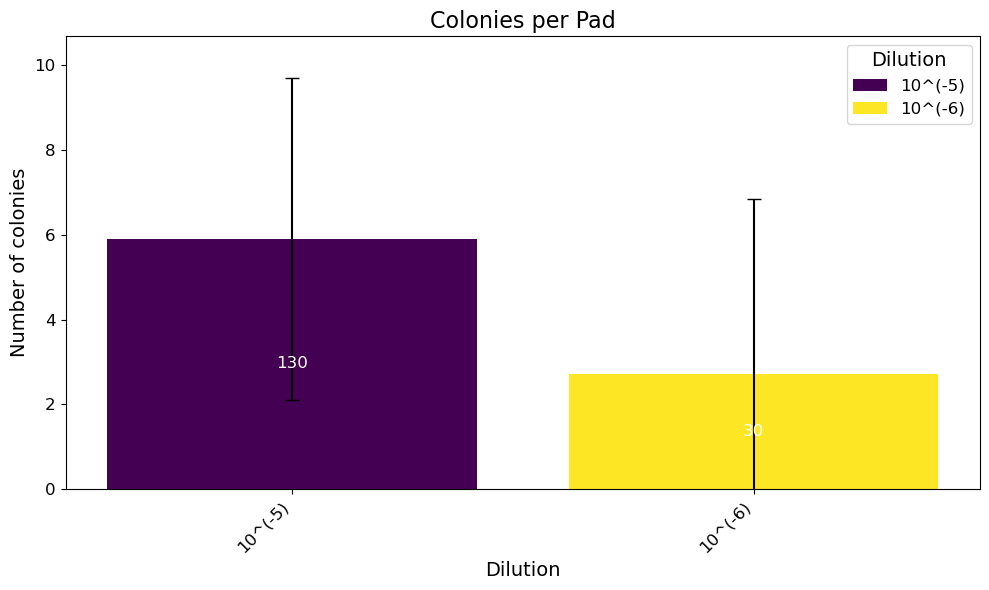

In [109]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap
area_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data_colonies)))

# Calculate the maximum y-axis limit
max_tm = plot_data_colonies['mean'] + plot_data_colonies['std']
global_max = max_tm.max()

# Plot the data
for pos, row in plot_data_colonies.iterrows():
    ax.bar(pos, row['mean'], yerr=row['std'], capsize=5, color=area_colors[pos], label=row['Dilution'])
    # Annotate the total number of colonies inside the bar
    ax.text(pos, row['mean']/2, f'{row["sum"]}', ha='center', va='center', color='white', fontsize=12)

# Set the title and labels
ax.set_title('Colonies per Pad', fontsize=16)
ax.set_xlabel('Dilution', fontsize=14)
ax.set_ylabel('Number of colonies', fontsize=14)
ax.set_xticks(np.arange(len(plot_data_colonies)))
ax.set_xticklabels(plot_data_colonies['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.legend(title="Dilution", title_fontsize=14, fontsize=12)

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('Colonies_pad.png', dpi=300)
# Show the plot
plt.show()

In [110]:
plot_data

,Dilution,mean,std,sum
0,10^(-5),244329.393547,112971.947433,130
1,10^(-6),732456.128804,198664.035451,30


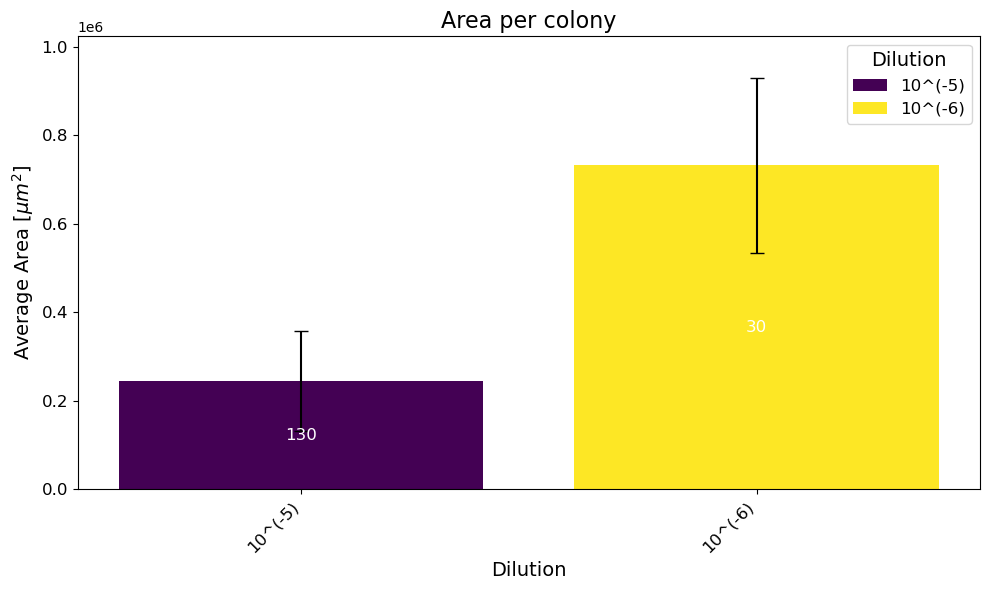

In [115]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap
area_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Calculate the maximum y-axis limit
max_tm = plot_data['mean'] + plot_data['std']
global_max = max_tm.max()

# Plot the data
for pos, row in plot_data.iterrows():
    ax.bar(pos, row['mean'], yerr=row['std'], capsize=5, color=area_colors[pos], label=row['Dilution'])
    # Annotate the total number of colonies inside the bar
    ax.text(pos, row['mean']/2, f'{row["sum"]}', ha='center', va='center', color='white', fontsize=12)

# Set the title and labels
ax.set_title('Area per colony', fontsize=16)
ax.set_xlabel('Dilution', fontsize=14)
ax.set_ylabel('Average Area [$\mu m^2$]', fontsize=14)
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.legend(title="Dilution", title_fontsize=14, fontsize=12)

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('Area_colony.png', dpi=300)
# Show the plot
plt.show()

In [112]:
total_area_per_pad_dilution = df.groupby(['Date', 'Machine', 'Pad', 'Dilution'])['area_max_um'].sum().reset_index(name='total_area')
area_per_pad = total_area_per_pad_dilution.groupby('Dilution')['total_area'].agg(['mean', 'std']).reset_index()

In [113]:
area_per_pad

,Dilution,mean,std
0,10^(-5),1.407416e+06,9.795501e+05
1,10^(-6),1.527326e+06,1.346664e+06


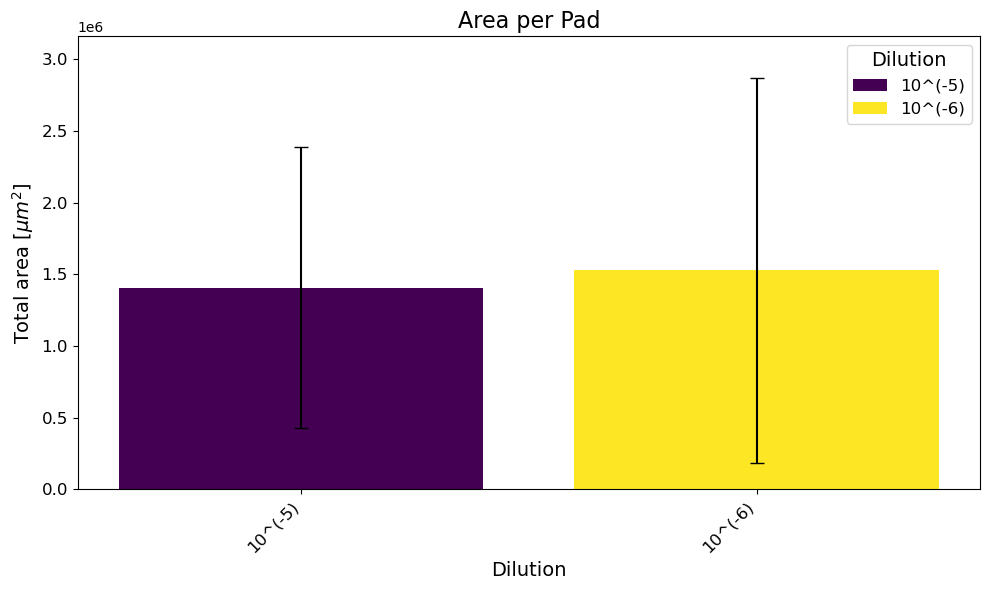

In [114]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap
area_colors = plt.cm.viridis(np.linspace(0, 1, len(area_per_pad)))

# Calculate the maximum y-axis limit
max_tm = area_per_pad['mean'] + area_per_pad['std']
global_max = max_tm.max()

# Plot the data
for pos, row in area_per_pad.iterrows():
    ax.bar(pos, row['mean'], yerr=row['std'], capsize=5, color=area_colors[pos], label=row['Dilution'])
    # Annotate the total number of colonies inside the bar
    #ax.text(pos, row['mean']/2, f'{row["sum"]}', ha='center', va='center', color='white', fontsize=12)

# Set the title and labels
ax.set_title('Area per Pad', fontsize=16)
ax.set_xlabel('Dilution', fontsize=14)
ax.set_ylabel('Total area [$\mu m^2$]', fontsize=14)
ax.set_xticks(np.arange(len(area_per_pad)))
ax.set_xticklabels(area_per_pad['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.legend(title="Dilution", title_fontsize=14, fontsize=12 )

# Adjust layout for better fit
plt.tight_layout()
plt.savefig('Area_pad.png', dpi=300)

# Show the plot
plt.show()